In [1]:
# %pip install lightning -q

In [663]:
import collections
import contextlib
import functools
import os
from tqdm.auto import tqdm
import copy

import torch
from torch import nn
import torch.nn.functional as F

import torchvision as tv
import torchvision.transforms.v2
from torchmetrics.functional import accuracy

try:
    import lightning.pytorch as pl
except ImportError:
    import pytorch_lightning as pl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Utilities
def compute_mean_std(dataset):
    r'''Use Welford's method to get the mean and std

    See https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Online_algorithm

    We use Welford instead of naive, as the sum of all squares might be extremely large,
    which might cause a numerical instability when taking the square root
    '''
    single_sample = np.array(dataset[0][0])  # To get the dimensions
    num_channels = 1 if single_sample.ndim < 3 else single_sample.shape[2]
    mean = np.zeros((num_channels, ))
    M2 = np.zeros((num_channels, ))
    count = 0

    for image, _ in dataset:
        image = np.array(image) / 255.0
        image = image.reshape(*image.shape[:2], num_channels)
        count += (image.shape[0] * image.shape[1])
        delta = image - mean
        mean += np.sum(delta, (0, 1)) / count
        M2 += np.sum(delta * (image - mean), (0, 1))

    variance = M2 / count
    std_dev = np.sqrt(variance)

    return mean, std_dev

def simple_mia(model, train_subset, val_subset, criterion, n_splits=5, max_samples_per_subset=100_000):
    r'''Simple MIA based on per-sample loss distribution.

    Args:
        model: PyTorch model
        train_subset: Dataloader that the model was trained on
        val_subset: Dataloader that the model never saw during training
        criterion: Loss function. IMPORTANT: Make sure the 'reduction' is set to "none"
        n_splits: Number of splits to use for cross-validation

    Returns:
        1. Cross-validation score for a succesful attack
        2. 
    '''
    from sklearn import linear_model, model_selection
    assert getattr(criterion, 'reduction', 'none') == 'none'

    # Step 1. Get the member and non-member losses
    all_losses = []
    all_members = []
    with torch.no_grad():
        # Lightning doesn't like when others mess with its internal parameters
        # -- save the old to restore later
        _old_training = model.training
        model.eval()
        for member, dataloader in zip([1, 0], [train_subset, val_subset]):
            losses = []
            for x, y in dataloader:
                y_hat = model(x)
                loss = criterion(y_hat, y).cpu().detach().numpy().tolist()
                losses.extend(loss)
            losses = losses[:max_samples_per_subset]
            all_losses.extend(losses)
            all_members.extend([member] * len(losses))
        model.training = _old_training
    all_losses = np.array(all_losses).reshape(-1, 1)
    all_members = np.array(all_members)

    # Step 2. Create an attack model
    attack_model = linear_model.LogisticRegression(class_weight='balanced')
    # Step 3. Create CV splits
    cv = model_selection.StratifiedShuffleSplit(n_splits=n_splits)
    # Step 4. Create CV scores -- replace with 'cross_validate' to produce a model instead of scores
    mia_scores = model_selection.cross_val_score(
        attack_model, all_losses, all_members, cv=cv, scoring='accuracy'
    )
    return mia_scores

# Environment
torch.set_float32_matmul_precision('medium')

# Constants
data_dir = './data/'

# Data

1. Pretraining Datasets
    1. ~~[TinyImageNet](https://paperswithcode.com/dataset/tiny-imagenet)~~
    1. [MNIST](https://paperswithcode.com/dataset/mnist)
1. Domain Datasets:
    1. ~~[MNIST-M](https://paperswithcode.com/dataset/mnist-m)~~
    1. [EMNIST](https://paperswithcode.com/dataset/emnist) (digits split)
1. Adaptation strategy:
    1. Finetuning


In [666]:
# Datamodules

dataset_classes = {
    'MNIST': tv.datasets.MNIST,
    'EMNIST': functools.partial(tv.datasets.EMNIST, split='mnist')
}


class MNISTDataModule(pl.LightningDataModule):
    def __init__(self,
                 dataset: str,
                 data_dir: str,
                 batch_size: int = 32,
                 seed: int = 42,
                 mean_std: tuple = None,  # Mean and Std
                ):
        super().__init__()
        self._dataset_cls = None  # This is the callable that will be used to create the dataset
        self._dataset_name = None

        self.dataset = dataset
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.seed = seed

        self.transform = tv.transforms.v2.Compose([
            tv.transforms.v2.ToImage(),
            # tv.transforms.v2.ToDtype(torch.uint8, scale=True),  # Only use if there are image transformation later
            tv.transforms.v2.ToDtype(torch.float32, scale=True),   # Normalize expects float input
            # Normalization parameters will be added later
            # tv.transforms.v2.Normalize(mean=1.0, std=1.0),
        ])

        self._mean_std = None
        self.mean_std = mean_std

    @property
    def mean_std(self):
        return self._mean_std

    @mean_std.setter
    def mean_std(self, ms: tuple):
        if ms == self._mean_std:
            return
        self._mean_std = ms
        # Find the normalization layer in the transorms
        tr = None
        for idx, tr in enumerate(self.transform.transforms):
            if isinstance(tr, (tv.transforms.v2.Normalize, tv.transforms.Normalize)):
                tr_idx = idx  # For scope
                break
        else:
            tr = tv.transforms.v2.Normalize(mean=[1.0], std=[1.0])
            self.transform.transforms.append(tr)
            tr_idx = len(self.transform.transforms) - 1

        if ms is None:  # Remove the normalization
            del self.transform.transforms[tr_idx]
            return

        tr.mean = ms[0]
        tr.std = ms[1]

    @property
    def dataset(self):
        if self._dataset_cls is None:
            return None
        return self._dataset_name

    @dataset.setter
    def dataset(self, name: str):
        name = name.upper()
        self._dataset_cls = dataset_classes[name]
        self._dataset_name = name

    def prepare_data(self):
        # Download
        train_set = self._dataset_cls(self.data_dir, train=True, download=True)
        self._dataset_cls(self.data_dir, train=False, download=True)
        # If the normalization was not provided, compute it here
        if self._mean_std is None:
            self.mean_std = compute_mean_std(train_set)
        return self

    def setup(self, stage: str):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit":
            mnist_full = self._dataset_cls(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = torch.utils.data.random_split(
                mnist_full, [55000, 5000], generator=torch.Generator().manual_seed(self.seed)
            )

        # Assign test dataset for use in dataloader(s)
        if stage == "test":
            self.mnist_test = self._dataset_cls(self.data_dir, train=False, transform=self.transform)

        if stage == "predict":
            self.mnist_predict = self._dataset_cls(self.data_dir, train=False, transform=self.transform)

        return self

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.mnist_train,
                                           batch_size=self.batch_size,
                                           persistent_workers=True,
                                           shuffle=True,
                                           num_workers=os.cpu_count())

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.mnist_val,
                                           batch_size=self.batch_size,
                                           persistent_workers=True,
                                           # shuffle=True,
                                           num_workers=os.cpu_count(),)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.mnist_test,
                                           batch_size=self.batch_size,
                                           persistent_workers=False,
                                           num_workers=os.cpu_count())

    def predict_dataloader(self):
        return torch.utils.data.DataLoader(self.mnist_predict,
                                           batch_size=self.batch_size,
                                           persistent_workers=False,
                                           num_workers=os.cpu_count())

    # def teardown(self, stage: str):
    #     # Used to clean-up when the run is finished
    #     pass

In [667]:
# Setup and prepare the data to be able to show images
mnist_datamodule = MNISTDataModule('mnist', data_dir=data_dir, batch_size=512, seed=42)\
                    .prepare_data()\
                    .setup('fit')
emnist_datamodule = MNISTDataModule('emnist', data_dir=data_dir, batch_size=512, seed=42)\
                    .prepare_data()\
                    .setup('fit')
# EMNIST is a transposed variant
emnist_datamodule.transform.transforms.append(lambda img: img.transpose(-1, -2))

torch.Size([10, 10, 30, 30])
torch.Size([10, 10, 30, 30])


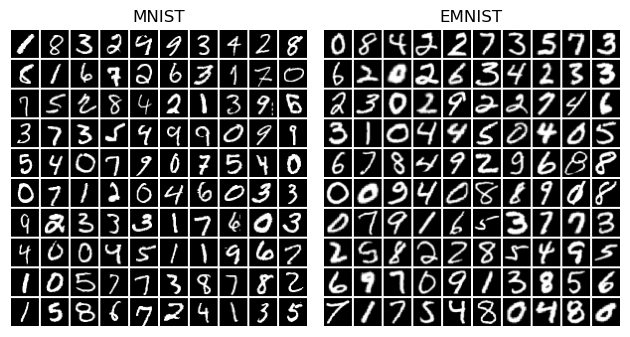

In [668]:
def show_imgs(imgs, ax=None):
    if ax is None:
        ax = plt.gca()
    # imgs: R x C x H x W
    imgs = F.pad(imgs, [1, 1, 1, 1], mode='constant', value=255)  # padding is lrtb
    print(imgs.shape)
    R, C, H, W = imgs.shape
    imgs = imgs.transpose(1, 2)  # R x H x C x W
    imgs = imgs.reshape(R * H, C * W)  # RH x CW

    ax.imshow(imgs, cmap='gray')
    ax.axis('off')
    return ax

# Combine some images to show
rows = 10
cols = 10

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

idx = np.random.choice(55000, rows * cols)
imgs = mnist_datamodule.mnist_train.dataset.data[idx].reshape(rows, cols, 28, 28)
show_imgs(imgs, ax=ax[0])
ax[0].set_title('MNIST')

idx = np.random.choice(55000, rows * cols)
imgs = emnist_datamodule.mnist_train.dataset.data[idx].reshape(rows, cols, 28, 28).transpose(-1, -2)
show_imgs(imgs, ax=ax[1])
ax[1].set_title('EMNIST')

plt.tight_layout()

# Model

1. Architectures
    1. Simple CNN for baseline
    1. Simple ViT for peft evaluation

In [679]:
class CNNModule(pl.LightningModule):
    def __init__(self, in_channels=1, num_classes: int=10, dropout:float = 0.5, arch: list = None):
        super().__init__()

        self.num_classes = num_classes
        self.arch = arch or {
            'back': [16],  # Conv
            'back_out': 16,
            'head_in': 5,         # Spatial dimensionality to reduce the linear's inputs (avgpool spatial)
            'head': [360],     # Linear hidden
            'head_dropout': dropout,
            'in_channels': in_channels,
        }
        self.model = self._make_model()
        self.learning_rate = 0.01  # Need this for finetuning
        self.T_max = 50
        # self.criterion = F.cross_entropy

        self.save_hyperparameters()

    def forward(self, *args, **kwargs):
        return self.model(*args, **kwargs)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.T_max)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx, dataloader_idx=0):
        loss, y_hat = self._shared_step(batch, batch_idx)
        metrics = {"train_loss": loss}
        # Remove this if too slow
        # with self.no_grad():
        y = batch[1]
        acc = accuracy(y_hat, y, task='multiclass', num_classes=self.num_classes)
        metrics['train_acc'] = acc
        self.log_dict(metrics,
                      prog_bar=True,
                      on_step=False,
                      on_epoch=True,
                      logger=True,)
        return loss

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        loss, acc = self._shared_eval_step(batch, batch_idx)
        metrics = {"val_acc": acc, "val_loss": loss}
        self.log_dict(metrics,
                      prog_bar=True,
                      on_step=False,
                      on_epoch=True,
                      logger=True,)
        return metrics

    def test_step(self, batch, batch_idx, dataloader_idx=0):
        loss, acc = self._shared_eval_step(batch, batch_idx)
        metrics = {"test_acc": acc, "test_loss": loss}
        self.log_dict(metrics)
        return metrics

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.model(x)
        return y_hat

    def _shared_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        return loss, y_hat

    def _shared_eval_step(self, batch, batch_idx):
        x, y = batch
        loss, y_hat = self._shared_step(batch, batch_idx)
        acc = accuracy(y_hat, y, task='multiclass', num_classes=self.num_classes)
        return loss, acc

    # Utilities
    def _make_model(self):
        model = nn.Sequential()

        in_channels = self.arch['in_channels']
        out_channels = self.arch['back_out']
        output_size = self.arch['head_in']
        for num_channels in self.arch['back']:
            model.append(nn.Conv2d(in_channels, num_channels, 3, stride=2, padding=1))
            model.append(nn.ReLU(inplace=True))
            in_channels = num_channels
        model.append(nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1))
        model.append(nn.AdaptiveAvgPool2d(output_size))
        model.append(nn.Flatten())

        in_channels = out_channels * output_size * output_size
        dropout = self.arch['head_dropout']
        for num_channels in self.arch['head']:
            model.append(nn.Linear(in_channels, num_channels))
            model.append(nn.ReLU(inplace=True))
            if dropout > 0.0:
                model.append(nn.Dropout(p=dropout))
            in_channels = num_channels
        model.append(nn.Linear(in_channels, self.num_classes))

        return model

    def num_parameters(self):
        stats = {'total': 0, 'trainable': 0, 'buffers': 0}
        for param in self.parameters():
            stats['total'] += param.numel()
            if param.requires_grad:
                stats['trainable'] += param.numel()
        for buf in self.buffers():
            stats['buffers'] += buf.numel()
        return stats

    @contextlib.contextmanager
    def no_grad(self):
        _old_training = self.model.training
        with torch.no_grad():
            try:
                yield self.model.eval()
            finally:
                self.model.training = _old_training

cnnmodel = CNNModule(dropout=0.5)
print(cnnmodel)
for name, param in cnnmodel.named_parameters():
    print(f'{name} {param.numel()}')
cnnmodel.num_parameters()


CNNModule(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): AdaptiveAvgPool2d(output_size=5)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=400, out_features=360, bias=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=360, out_features=10, bias=True)
  )
)
model.0.weight 144
model.0.bias 16
model.2.weight 2304
model.2.bias 16
model.5.weight 144000
model.5.bias 360
model.8.weight 3600
model.8.bias 10


{'total': 150450, 'trainable': 150450, 'buffers': 0}

# Train the baseline CNN

In [680]:
max_epochs = 25
cnnmodel.T_max = max_epochs

cnntrainer = pl.Trainer(
    max_epochs=max_epochs,
    logger=pl.loggers.CSVLogger('.')
)
cnntrainer.fit(model=cnnmodel, datamodule=mnist_datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 150 K 
-------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=25` reached.


In [681]:
history = pd.read_csv(
    os.path.join(cnntrainer.loggers[0].log_dir, 'metrics.csv')
)

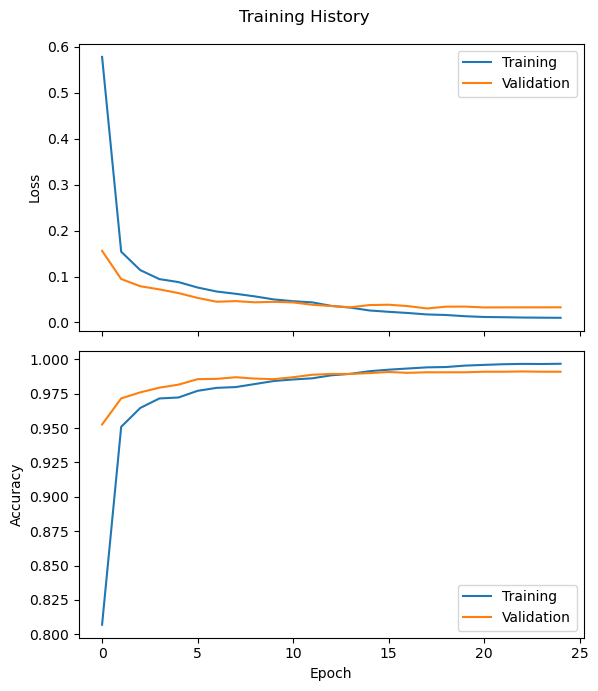

In [682]:
train_mask = history['train_loss'].notnull()
val_mask = history['val_loss'].notnull()

fig, ax = plt.subplots(2, sharex=True, figsize=(6, 7))

fig.suptitle(f'Training History')

ax[0].plot(history['epoch'][train_mask], history['train_loss'][train_mask], label='Training')
ax[0].plot(history['epoch'][val_mask], history['val_loss'][val_mask], label='Validation')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(history['epoch'][train_mask], history['train_acc'][train_mask], label='Training')
ax[1].plot(history['epoch'][val_mask], history['val_acc'][val_mask], label='Validation')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

ax[1].set_xlabel('Epoch')

plt.tight_layout()

In [687]:
print(f'Accuracy / Loss for MNIST dataset:')
cnntrainer.test(
    model=cnnmodel,
    dataloaders=[mnist_datamodule.train_dataloader(),
                 mnist_datamodule.val_dataloader()])
print(f'Accuracy / Loss for EMNIST dataset:')
cnntrainer.test(
    model=cnnmodel,
    dataloaders=[emnist_datamodule.train_dataloader(),
                 emnist_datamodule.val_dataloader()])

mia_scores = simple_mia(cnnmodel.model,
                        mnist_datamodule.train_dataloader(),
                        emnist_datamodule.train_dataloader(),
                        nn.CrossEntropyLoss(reduction='none'),
                        n_splits=10,
                        max_samples_per_subset=100_000)
print(f'MIA score for MNIST(member) vs. EMNIST(non-member) dataset: {mia_scores.mean():.2%}')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Accuracy / Loss for MNIST dataset:


/home/takeshi/micromamba/envs/ai/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9995090365409851       0.9909999966621399
        test_loss          0.0024876222014427185     0.03305107727646828
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Accuracy / Loss for EMNIST dataset:


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9300181865692139       0.9287999868392944
        test_loss           0.44957059621810913      0.46536415815353394
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
MIA score for MNIST(member) vs. EMNIST(non-member) dataset: 56.80%


# Adapt to a new domain

- This is not a true adaptation, as the domain still the same
- Model is overfitting, so might not notice the difference in validation score -- pay attention to the training score only

In [688]:
finetune_epochs = 5

cnnmodel_adapt = CNNModule(dropout=0.5)
cnnmodel_adapt.model = copy.deepcopy(cnnmodel.model)

cnnmodel_adapt.T_max = finetune_epochs
cnnmodel_adapt.learning_rate = 1e-4

# Freeze all non-linear layers + last convolution
freeze_upto = 4
for idx in range(freeze_upto):
    for param in cnnmodel_adapt.model[idx].parameters():
        param.requires_grad = False

print(cnnmodel_adapt)

cnntrainer_adapt = pl.Trainer(
    max_epochs=finetune_epochs,
    logger=pl.loggers.CSVLogger('.')
)

num_params = cnnmodel_adapt.num_parameters()
print(num_params)
print(f'Fraction trainable: {num_params["trainable"]/num_params["total"]:.2%}')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


CNNModule(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): AdaptiveAvgPool2d(output_size=5)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=400, out_features=360, bias=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=360, out_features=10, bias=True)
  )
)
{'total': 150450, 'trainable': 147970, 'buffers': 0}
Fraction trainable: 98.35%


In [689]:
# Show quality on the target dataset
cnntrainer_adapt.test(
    model=cnnmodel_adapt,
    dataloaders=[mnist_datamodule.train_dataloader(),
                 mnist_datamodule.val_dataloader()]);

cnntrainer_adapt.test(
    model=cnnmodel_adapt,
    dataloaders=[emnist_datamodule.train_dataloader(),
                 emnist_datamodule.val_dataloader()]);

mia_scores = simple_mia(cnnmodel_adapt.model,
                        mnist_datamodule.train_dataloader(),
                        emnist_datamodule.train_dataloader(),
                        nn.CrossEntropyLoss(reduction='none'),
                        n_splits=10,
                        max_samples_per_subset=100_000)
print(f'MIA score for MNIST(member) vs. EMNIST(non-member) dataset: {mia_scores.mean():.2%}')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/takeshi/micromamba/envs/ai/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |                                                                                                    …

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9995090961456299       0.9909999966621399
        test_loss          0.0024876228999346495     0.03305107727646828
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9300181865692139       0.9287999868392944
        test_loss           0.44957059621810913      0.46536415815353394
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
MIA score for MNIST(member) vs. EMNIST(non-member) dataset: 56.69%


In [690]:
# Finetune for N epochs
cnntrainer_adapt.fit(model=cnnmodel_adapt, datamodule=emnist_datamodule)

# Show quality on the target dataset
cnntrainer_adapt.test(
    model=cnnmodel_adapt,
    dataloaders=[mnist_datamodule.train_dataloader(),
                 mnist_datamodule.val_dataloader()]);
cnntrainer_adapt.test(
    model=cnnmodel_adapt,
    dataloaders=[emnist_datamodule.train_dataloader(),
                 emnist_datamodule.val_dataloader()]);

mia_scores = simple_mia(cnnmodel_adapt.model,
                        mnist_datamodule.train_dataloader(),
                        emnist_datamodule.train_dataloader(),
                        nn.CrossEntropyLoss(reduction='none'),
                        n_splits=10,
                        max_samples_per_subset=100_000)
print(f'MIA score for MNIST(member) vs. EMNIST(non-member) dataset: {mia_scores.mean():.2%}')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 150 K 
-------------------------------------
147 K     Trainable params
2.5 K     Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/takeshi/micromamba/envs/ai/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9950363636016846       0.9843999743461609
        test_loss          0.013718309812247753      0.05452264845371246
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9774909019470215       0.9749999642372131
        test_loss           0.11274932324886322      0.14869022369384766
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
MIA score for MNIST(member) vs. EMNIST(non-member) dataset: 51.36%


## Simulate LoRA

In [691]:
class LinearLoRA(nn.Linear):
    def __init__(self, *args, rank=1, **kwargs):
        super().__init__(*args, **kwargs)
        self.rank = rank
        
        self.register_parameter('residual_a', None)
        self.register_parameter('residual_b', None)
        self.make_residual(method='random')
        
    def make_residual(self, method: str = 'random'):
        # Ideally, we want to have a proper decomposition
        if method == 'random':
            # Randomly initializes the residual
            A = torch.randn(self.out_features, self.rank, device=self.weight.device, dtype=self.weight.dtype)
            B = torch.randn(self.rank, self.in_features, device=self.weight.device, dtype=self.weight.dtype)
        elif method == 'identity':
            # Initializes A randomly, and computes B as its pseudoinverse
            # Note -- the pseudo inverse is not going to result in identity
            # The reason is that A is considered to have more rows than columns
            # which implies that its injective
            # However, we use its inverse as surjective "right inverse", which does not imply identity
            A = torch.randn(self.out_features, self.rank, device=self.weight.device, dtype=self.weight.dtype)
            B = torch.linalg.pinv(A)
            # Change the dimensions of B -- number of columns is "out_features"
            if self.in_features < self.out_features:
                B = B[:, :self.in_features]
            elif self.in_features > self.out_features:
                B = F.pad(B, [0, self.in_features-self.out_features, 0, 0])                
        elif method == 'zero':
            # Initializes A and B, after which each element is scaled by
            # a large constant scaled by their norms
            # That forces each value to be in the scale of 1/scale of their norm
            # Note -- it's a bad idea to set these to zero, as the gradients will collapse
            scale = 100
            A = torch.randn(self.out_features, self.rank, device=self.weight.device, dtype=self.weight.dtype)
            B = torch.randn(self.rank, self.in_features, device=self.weight.device, dtype=self.weight.dtype)
            A = A / (scale * A.norm())
            B = B / (scale * B.norm())
        else:
            raise ValueError(f'Unknown method "{method}"...')
        self.residual_a = nn.Parameter(A)
        self.residual_b = nn.Parameter(B)
        return self

    def forward(self, x):
        residual = self.residual_a @ self.residual_b
        weight = self.weight + residual
        return F.linear(x, weight, self.bias)

    @classmethod
    def from_linear(cls, other, rank=1, method='random'):
        cl = LinearLoRA(other.in_features, other.out_features, bias=(other.bias is not None), rank=rank)
        cl.weight = other.weight
        cl.bias = other.bias
        cl.make_residual(method=method)
        return cl


In [696]:
cnnmodel_adapt = CNNModule(dropout=0.5)
cnnmodel_adapt.model = copy.deepcopy(cnnmodel.model)

cnnmodel_adapt.T_max = finetune_epochs
cnnmodel_adapt.learning_rate = 1e-3

# Freeze all non-linear layers + last convolution
freeze_upto = 4
for idx in range(freeze_upto):
    for param in cnnmodel_adapt.model[idx].parameters():
        param.requires_grad = False

# Replace the model's linear layers
for name, child in cnnmodel_adapt.model.named_children():
    if isinstance(child, nn.Linear) and child.weight.requires_grad:
        cnnmodel_adapt.model[int(name)] = LinearLoRA.from_linear(child, rank=2, method='identity')
        cnnmodel_adapt.model[int(name)].weight.requires_grad = False
        cnnmodel_adapt.model[int(name)].residual_a.requires_grad = True
        cnnmodel_adapt.model[int(name)].residual_b.requires_grad = True
        # Keep bias unfrozen, as it is realtively small

print(cnnmodel_adapt)

cnntrainer_adapt = pl.Trainer(
    max_epochs=finetune_epochs,
    logger=pl.loggers.CSVLogger('.')
)

num_params = cnnmodel_adapt.num_parameters()
print(num_params)
print(f'Fraction trainable: {num_params["trainable"]/num_params["total"]:.2%}')

cnntrainer_adapt.test(
    model=cnnmodel_adapt,
    dataloaders=[mnist_datamodule.train_dataloader(),
                 mnist_datamodule.val_dataloader()])

cnntrainer_adapt.test(
    model=cnnmodel_adapt,
    dataloaders=[emnist_datamodule.train_dataloader(),
                 emnist_datamodule.val_dataloader()])

mia_scores = simple_mia(cnnmodel_adapt.model,
                        mnist_datamodule.train_dataloader(),
                        emnist_datamodule.train_dataloader(),
                        nn.CrossEntropyLoss(reduction='none'),
                        n_splits=10,
                        max_samples_per_subset=100_000)
print(f'MIA score for MNIST(member) vs. EMNIST(non-member) dataset: {mia_scores.mean():.2%}')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


CNNModule(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): AdaptiveAvgPool2d(output_size=5)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): LinearLoRA(in_features=400, out_features=360, bias=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): LinearLoRA(in_features=360, out_features=10, bias=True)
  )
)
{'total': 152710, 'trainable': 2630, 'buffers': 0}
Fraction trainable: 1.72%


/home/takeshi/micromamba/envs/ai/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |                                                                                                    …

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9993636608123779       0.9905999898910522
        test_loss           0.00281164376065135      0.03357604891061783
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9282909035682678       0.9271999597549438
        test_loss           0.46006253361701965      0.4781342148780823
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
MIA score for MNIST(member) vs. EMNIST(non-member) dataset: 56.98%


In [697]:
# Finetune for N epochs
cnntrainer_adapt.fit(model=cnnmodel_adapt, datamodule=emnist_datamodule)

# Show quality on the target dataset
cnntrainer_adapt.test(
    model=cnnmodel_adapt,
    dataloaders=[mnist_datamodule.train_dataloader(),
                 mnist_datamodule.val_dataloader()])

cnntrainer_adapt.test(
    model=cnnmodel_adapt,
    dataloaders=[emnist_datamodule.train_dataloader(),
                 emnist_datamodule.val_dataloader()])

mia_scores = simple_mia(cnnmodel_adapt.model,
                        mnist_datamodule.train_dataloader(),
                        emnist_datamodule.train_dataloader(),
                        nn.CrossEntropyLoss(reduction='none'),
                        n_splits=10,
                        max_samples_per_subset=100_000)
print(f'MIA score for MNIST(member) vs. EMNIST(non-member) dataset: {mia_scores.mean():.2%}')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 152 K 
-------------------------------------
2.6 K     Trainable params
150 K     Non-trainable params
152 K     Total params
0.611     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/takeshi/micromamba/envs/ai/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9718363285064697       0.9599999785423279
        test_loss           0.09427198767662048      0.14660616219043732
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.979236364364624       0.9775999784469604
        test_loss           0.0996456891298294       0.13297387957572937
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
MIA score for MNIST(member) vs. EMNIST(non-member) dataset: 49.41%


# Use Opacus for noise injection

In [ ]:
max_grad_norm = 1.2
epsilon = 50.0
delta = 1e-5
epochs = 20
learning_rate = 1e-4

In [700]:
from opacus.validators import ModuleValidator

ModuleValidator.validate(cnnmodel, strict=False)

[]

[rank: 0] Received SIGTERM: 15
[rank: 0] Received SIGTERM: 15
[rank: 0] Received SIGTERM: 15


In [ ]:
model, 